## Baseline Model : 단순 회귀

In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import info

In [2]:
%%time
base_query = """
WITH base_data AS 
(
    SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
    FROM (
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE 
            EXTRACT(MONTH from pickup_datetime) = 1
            and pickup_latitude  <= 90 and pickup_latitude >= -90
        ) AS nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) AS gis 
    ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT
    zip_code,
    pickup_hour,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    cnt
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt,
        zip_code
    FROM base_data
    GROUP BY pickup_hour, zip_code
)
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=info['project'])

CPU times: user 1.38 s, sys: 105 ms, total: 1.48 s
Wall time: 16.8 s


#### Target 분포 파악
- 왼쪽으로 심하게 몰린 비대칭적인 분포를 띄기에 log를 적용해 Normalization

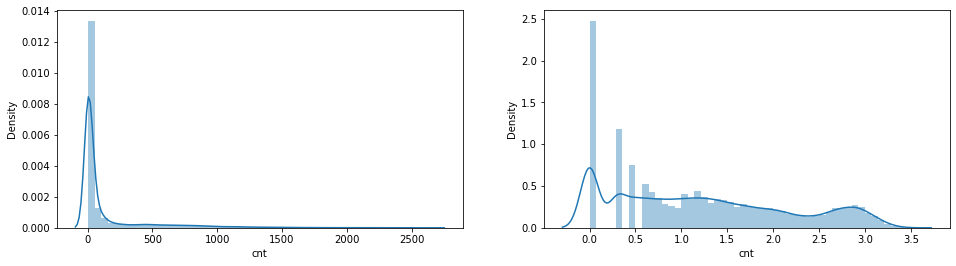

In [10]:
plt.figure(figsize=(16, 4))

# 전체 분포
plt.subplot(121)
sns.distplot(base_df['cnt']);

plt.subplot(122)
# 전체 분포 log화
sns.distplot(np.log10(base_df['cnt']));

In [11]:
# log_cnt 생성
base_df['log_cnt'] = np.log10(base_df['cnt'])

#### Train / Test Split

In [18]:
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : train/test 기준 일
    """
    criteria = str((max(df['pickup_hour']) - pd.Timedelta(days=period)).date())
    train_df = df[df['pickup_hour'] < criteria]
    test_df = df[df['pickup_hour'] >= criteria]
    return train_df, test_df

In [19]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [20]:
del train_df['pickup_hour']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

#### Simple Regression
- One Hot Encoding X

In [21]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [22]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)

test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred

test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [23]:
# 실제값과 로그변환을 한 예측값 비교
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


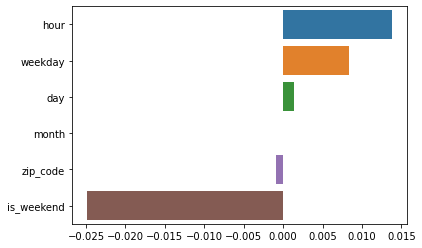

In [25]:
# Feature Importance
coef = pd.Series(lr_reg.coef_ , index=x_train.columns).sort_values(ascending=False)
sns.barplot(x=coef.values , y=coef.index);

#### Simple Regression
- One Hot Encoding 적용

In [39]:
enc = OneHotEncoder(handle_unknown='ignore')

ohe_output = enc.fit_transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

ohe_df.head(2)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt,zip_code_10001,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,11373,2015-01-01,1,1,3,0,0,14,1.146128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11237,2015-01-01,1,1,3,0,0,38,1.579784,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test_period(ohe_df, 7)

train_df.drop(columns=['zip_code', 'pickup_hour'], inplace=True)
test_df.drop(columns=['zip_code', 'pickup_hour'], inplace=True)

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [41]:
lr_reg_2 = LinearRegression()
lr_reg_2.fit(x_train, y_train_log)
pred_2 = lr_reg_2.predict(x_test)

test_df['pred_log']= pred_2
test_df['pred_reverse'] = 10**pred_2
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [42]:
# inf를 제외하기 위한 전처리
test_df = test_df[np.isfinite(test_df).all(1)]

In [43]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.667115,66.948895,27025.737576


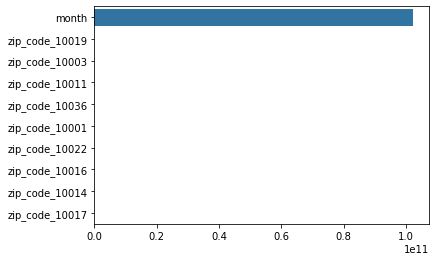

In [44]:
coef = pd.Series(lr_reg_2.coef_ , index=x_train.columns).sort_values(ascending=False)[:10]
sns.barplot(x=coef.values , y=coef.index);

- 성능적인 측면에서는 첫번째 모델보다 성능이 좋아졌지만 해석적인 측면에서는 안좋아진 모델이라고 할 수 있다.
- 그러나 현 프로젝트는 수요예측이 중요한 모델이기에 해석가능성 및 Inference는 고려하지 않는다.